In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F

from sklearn.datasets import load_boston
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
from torch.utils.data import DataLoader

np.random.seed(42)

In [2]:
raw_data = load_boston()

data = raw_data.data 
np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10 

X_train = data[:trainset_size, :]
X_test = data[trainset_size:, :]

In [3]:
# Normalize 
scaler = preprocessing. StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)
print(X_train.shape)
print(X_test.shape)

torch.Size([354, 13])
torch.Size([152, 13])


In [4]:
class Generator(nn.Module): 
    def __init__(self, noise_dim, hidden_dim, input_dim):
        super().__init__()
        
        self.input = nn.Linear(noise_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z):
        out = F.relu(self.input(z))
        out = F.relu(self.hidden(out))
        out = self.output(out)
        
        return out 

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
        out = self.output(out)
        
        return out

In [5]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 5 
NOISE_DIM = 2
N_EPOCHS = 100
lr = 1e-4

In [6]:
gen = Generator(NOISE_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)
dis = Discriminator(INPUT_DIM, HIDDEN_DIM).type(torch.float64)

In [7]:
optimizer_D = torch.optim.Adam(list(dis.parameters()), lr=lr)
optimizer_G = torch.optim.Adam(list(gen.parameters()), lr=lr)

In [8]:
loo = LeaveOneOut()
print(loo.get_n_splits(X_train))
print(len(X_train))

logsigmoid = torch.nn.LogSigmoid()

354
354


In [9]:
train_acc = []
loss_dis = []
loss_gen = []

for i in range(N_EPOCHS):
    train_acc.append(0)
    loss_dis.append(0)
    loss_gen.append(0)
    num_batches = 0
    
    for train_index, valid_index in loo.split(X_train):
        x_train, x_valid = X_train[train_index], X_train[valid_index]
        """ Training discriminator """
        ## Zero grad 
        optimizer_D.zero_grad()
        
        ## Forward pass
        # Pass actual data 
        out_D_dis = dis(x_train)

        # Pass generated data 
        noise = torch.distributions.Uniform(0, 1).sample((x_train.shape[0], NOISE_DIM)).type(torch.float64)
        out_G_dis = gen(noise)
        out_DG_dis = dis(out_G_dis)

        ## Loss 
        loss_D = -torch.mean(logsigmoid(out_D_dis) + logsigmoid(1 - out_DG_dis))
        loss_dis[-1] += loss_D
        
        ## Backward 
        loss_D.backward()
        
        ## Update parameters
        optimizer_D.step()
        
        """ Train generator """
        ## Zero grad 
        optimizer_G.zero_grad()
        
        ## Forward pass 
        noise = torch.distributions.Uniform(0, 1).sample((x_train.shape[0], NOISE_DIM)).type(torch.float64)
        out_G_gen = gen(noise)
        out_DG_gen = dis(out_G_gen)
        
        # Loss 
        loss_G = -torch.mean(logsigmoid(out_DG_gen))
        loss_gen[-1] += loss_G
        
        """ Leave One Out Cross Validation """
        out_D_valid = dis(x_valid)
        out_D_valid = torch.nn.Sigmoid()(out_D_valid[0,0])
        out_D_valid_acc = int((out_D_valid > 0.5) == 1)
        
        train_acc[-1] += out_D_valid_acc
        
        noise = torch.distributions.Uniform(0, 1).sample((x_valid.shape[0], NOISE_DIM)).type(torch.float64)
        out_G_valid = gen(noise)
        out_DG_valid = dis(out_G_valid)
        out_DG_valid = torch.nn.Sigmoid()(out_DG_valid[0,0])
        out_DG_valid_acc = int((out_DG_valid > 0.5) == 0)
        
        train_acc[-1] += out_DG_valid_acc
        num_batches += 1
    
    loss_dis[-1] /= num_batches
    loss_gen[-1] /= num_batches
    train_acc[-1] /= num_batches * 2
    
    print("Epoch [%d / %d] average reconstruction error: %f" % (i+1, N_EPOCHS, train_acc[-1]) )

Epoch [1 / 100] average reconstruction error: 0.717514
Epoch [2 / 100] average reconstruction error: 0.950565
Epoch [3 / 100] average reconstruction error: 0.994350
Epoch [4 / 100] average reconstruction error: 0.998588
Epoch [5 / 100] average reconstruction error: 1.000000
Epoch [6 / 100] average reconstruction error: 0.998588
Epoch [7 / 100] average reconstruction error: 0.998588
Epoch [8 / 100] average reconstruction error: 0.998588
Epoch [9 / 100] average reconstruction error: 0.998588
Epoch [10 / 100] average reconstruction error: 0.998588
Epoch [11 / 100] average reconstruction error: 0.998588
Epoch [12 / 100] average reconstruction error: 1.000000
Epoch [13 / 100] average reconstruction error: 1.000000
Epoch [14 / 100] average reconstruction error: 1.000000
Epoch [15 / 100] average reconstruction error: 1.000000
Epoch [16 / 100] average reconstruction error: 1.000000
Epoch [17 / 100] average reconstruction error: 1.000000
Epoch [18 / 100] average reconstruction error: 1.000000
E

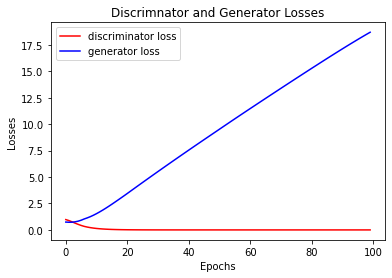

In [10]:
plt.plot(loss_dis, "r")
plt.plot(loss_gen, "b")
plt.legend(["discriminator loss", "generator loss"])
plt.title("Discrimnator and Generator Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()

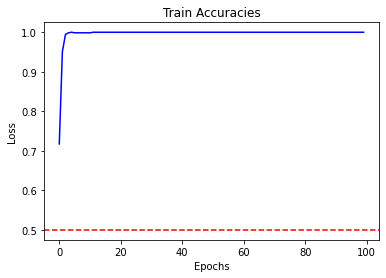

In [11]:
fig = plt.figure()
plt.plot(train_acc, color="b")
plt.axhline(0.5, linestyle='--', color="r")
plt.title("Train Accuracies")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [12]:
for i in range(100):
    # Generate data
    noise = torch.distributions.Uniform(0, 1).sample((X_test.shape[0], NOISE_DIM)).type(torch.float64)
    out_G_test = gen(noise)

    # Combine generated data and held out data 
    data = torch.cat((out_G_test, X_test))
    labels = torch.cat((torch.zeros(out_G_test.shape[0]), torch.ones(X_test.shape[0])))

    # Randomly mix the test data and generated data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    data = data[indices]
    labels = labels[indices].unsqueeze(1)

    out_D_test = dis(data)
    out_D_test = torch.nn.Sigmoid()(out_D_test)
    result = (out_D_test > 0.5).type(torch.float)
    acc = (result == labels).type(torch.float)
    mean_acc = torch.mean(acc)

    print("Test accuracy {}: {}".format(i + 1, mean_acc))

Test accuracy 1: 0.9967105388641357
Test accuracy 2: 0.9967105388641357
Test accuracy 3: 0.9967105388641357
Test accuracy 4: 0.9967105388641357
Test accuracy 5: 0.9967105388641357
Test accuracy 6: 0.9967105388641357
Test accuracy 7: 0.9967105388641357
Test accuracy 8: 0.9967105388641357
Test accuracy 9: 0.9967105388641357
Test accuracy 10: 0.9967105388641357
Test accuracy 11: 0.9967105388641357
Test accuracy 12: 0.9967105388641357
Test accuracy 13: 0.9967105388641357
Test accuracy 14: 0.9967105388641357
Test accuracy 15: 0.9967105388641357
Test accuracy 16: 0.9967105388641357
Test accuracy 17: 0.9967105388641357
Test accuracy 18: 0.9967105388641357
Test accuracy 19: 0.9967105388641357
Test accuracy 20: 0.9967105388641357
Test accuracy 21: 0.9967105388641357
Test accuracy 22: 0.9967105388641357
Test accuracy 23: 0.9967105388641357
Test accuracy 24: 0.9967105388641357
Test accuracy 25: 0.9967105388641357
Test accuracy 26: 0.9967105388641357
Test accuracy 27: 0.9967105388641357
Test accur

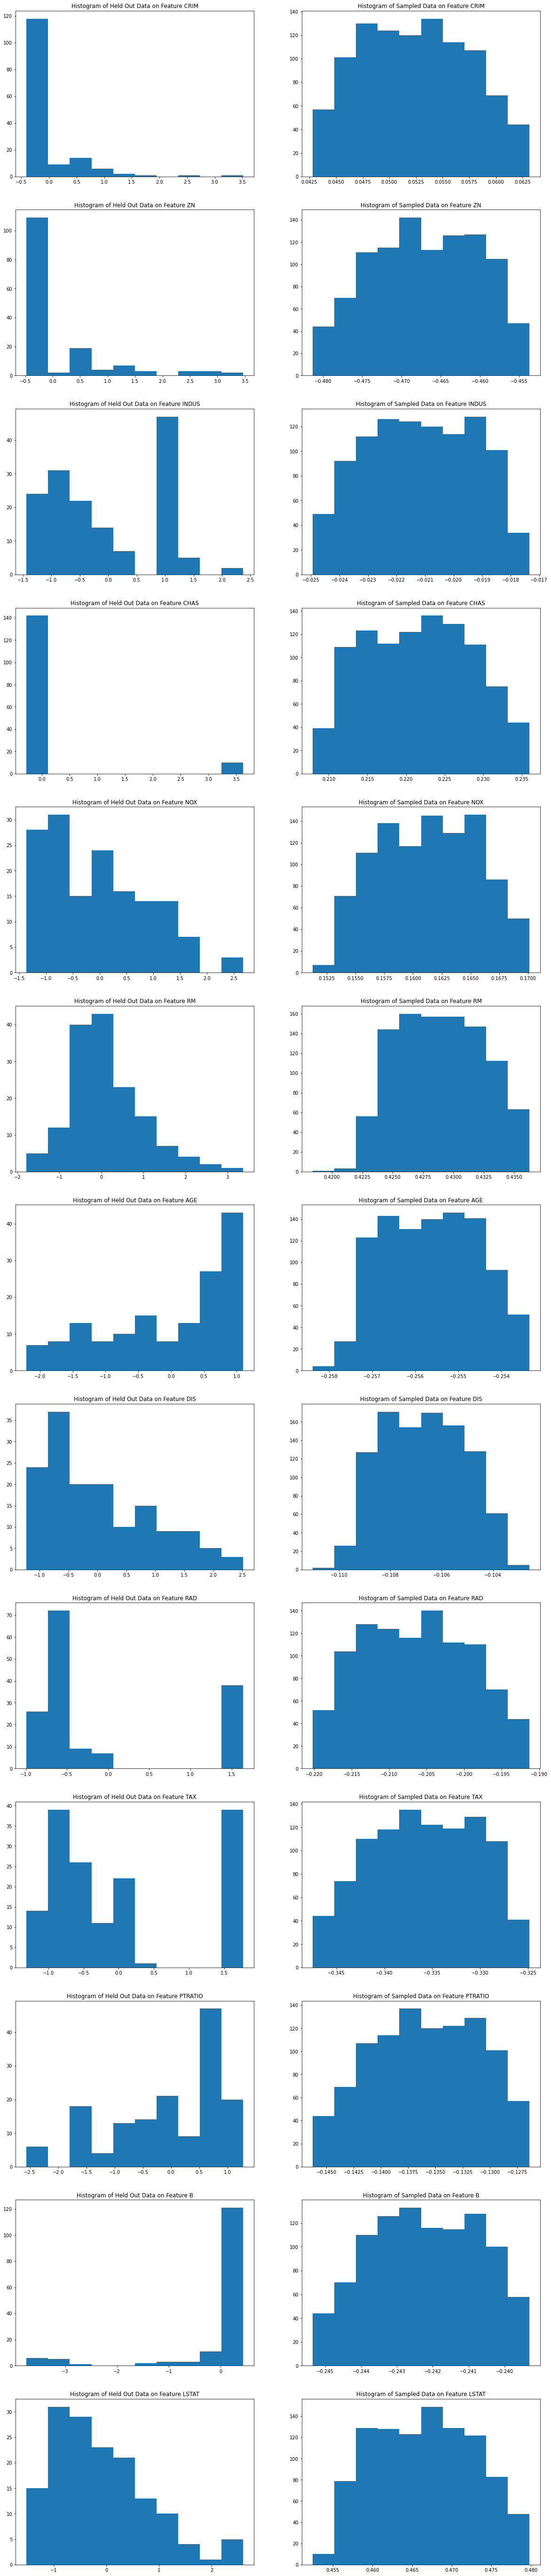

In [13]:
noise = torch.distributions.Uniform(0, 1).sample((1000, NOISE_DIM)).type(torch.float64)
outG = gen(noise)

x_out = outG.detach().numpy()
x_test = X_test.numpy()

figs, axs = plt.subplots(x_out.shape[1], 2, figsize=(20, 100))

for i in range(x_out.shape[1]):
    x_test_mean = x_test[:,i].mean()
    axs[i, 0].hist(x_test[:,i])
    axs[i, 0].set_title("Histogram of Held Out Data on Feature " + raw_data.feature_names[i])
    axs[i, 1].hist(x_out[:,i])
    axs[i, 1].set_title("Histogram of Sampled Data on Feature " + raw_data.feature_names[i])

plt.show()